In [ ]:
import numpy as np #2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.io import loadmat
from scipy import stats
import statsmodels.api as sm
plt.style.use("ggplot")        # pick any style you like
%matplotlib inline

from scipy.optimize import least_squares

In [3]:
from scipy.special import erf

In [4]:
from concurrent.futures import ProcessPoolExecutor
from typing import Iterable, Tuple, Dict, Optional

In [58]:
from scipy.stats import linregress

Import data

In [5]:
mat = loadmat(r"C:\Users\PORTATIL\MATLAB Drive\TFM\AllB_JF.mat")

In [6]:
Y     = np.asarray(mat["Y"])       # 540 x 2321
TNA   = np.asarray(mat["TNA"])     # same shape
F     = np.asarray(mat["F"])       # 540 x 5
rf    = np.asarray(mat["rf"]).flatten()  # 540 x 1 → flatten to 1D
style = np.asarray(mat["stylemat"])      # 2321 x 18
fundids = mat["fundids"].flatten()       # 2321 × 1 → fund ID for each column

T, N = Y.shape

In [7]:
# Time and Fund grids
time_idx = np.arange(T)
fund_idx = np.arange(N)

time_grid, fund_grid = np.meshgrid(time_idx, fund_idx, indexing='ij')
df = pd.DataFrame({
    "time": time_grid.ravel(),
    "fund_index": fund_grid.ravel(),
    "fund_id": fundids[fund_grid.ravel()],
    "Y": Y.ravel(),
    "TNA": TNA.ravel(),
    # add more fields if needed (e.g., TNA1, etc.)
})

In [8]:
style_df = pd.DataFrame(style, columns=[f"style_{i+1}" for i in range(style.shape[1])])
style_df["fund_id"] = fundids
df = df.merge(style_df, on="fund_id", how="left")
df.replace(-999, np.nan, inplace=True)
df.shape

(1253340, 23)

In [9]:
F_df = pd.DataFrame(F, columns=[f"F{i+1}" for i in range(F.shape[1])])
F_df["time"] = np.arange(F.shape[0])

# Merge into df
df = df.merge(F_df, on="time", how="left")

In [10]:
df = df.dropna(subset=["Y", "TNA"])
df.shape
df.head()

,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
5,0,5,100010,0.005069,64.361911,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
9,0,9,100019,0.158994,35.243098,0,0,0,1,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
15,0,15,100046,0.091393,57.922143,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
16,0,16,100047,0.135792,58.868593,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
18,0,18,100055,0.141008,3610.879183,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386


Smoothing functions

In [11]:
def S_h(q, K, h):
    """Smooth indicator  ≈ 1{q<=K}."""
    z = (K - q) / h
    # clip z to avoid overflow
    return 1.0 / (1.0 + np.exp(-np.clip(z, -700, 700)))

# ---------- 2. alpha formula -------------
def alpha_BG(params, q, h):
    """Compute alpha_it(h) for vector q (lagged sizes)."""
    a, b, K = params
    S = S_h(q, K, h)
    part1 = (a - b * q) * S
    part2 = (a * K - b * K**2) / q * (1.0 - S)
    return part1 + part2

# ---------- 3. per-fund objective --------
def residuals(params, q, alpha_target, h):
    """Vector of residuals to feed into NLLS."""
    return alpha_BG(params, q, h) - alpha_target

In [12]:

# ---------- 4. estimation wrapper --------
def estimate_fund(fund_df, h=0.02,
                  bounds=(( -1.0, -5.0,  0.0),   # (a_min, b_min, K_min)
                          (  2.0,  5.0,  np.inf))):
    """
    Estimate (a_i, b_i, K_i) by box-constrained LM/Trust-Region.
    fund_df needs columns 'q_lag' (or 'TNA') and 'Y'.
    """
    # Clean & vectorise
    q = fund_df["q_lag"].to_numpy(dtype=float)
    y = fund_df["Y"].to_numpy(dtype=float)
    mask = (~np.isnan(q)) & (~np.isnan(y)) & (q > 0)
    q, y = q[mask], y[mask]

    # Initial guesses
    a0 = np.nanmean(y)
    b0 = 0.0
    K0 = np.nanmedian(q)
    x0 = np.array([a0, b0, K0])

    # Solve
    res = least_squares(residuals, x0, bounds=bounds,
                        args=(q, y, h), method="trf", max_nfev=2000)

    return {"a": res.x[0],
            "b": res.x[1],
            "K": res.x[2],
            "cost": res.cost,
            "success": res.success,
            "h": h,
            "n_obs": len(q)}

In [13]:
# -------------------------------------------------------------
# No additional shift needed
df = df.sort_values(["fund_id", "time"])
df["q_lag"] = df["TNA"]        # already lagged in the .mat file
# -------------------------------------------------------------
results = []
for fund_id, g in df.groupby("fund_id"):
    est = estimate_fund(g, h=0.02)   # h = 0.02 as before
    est["fund_id"] = fund_id
    results.append(est)

est_df = pd.DataFrame(results)



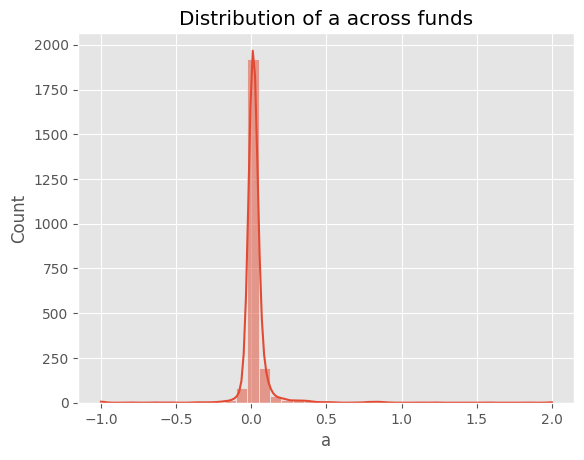

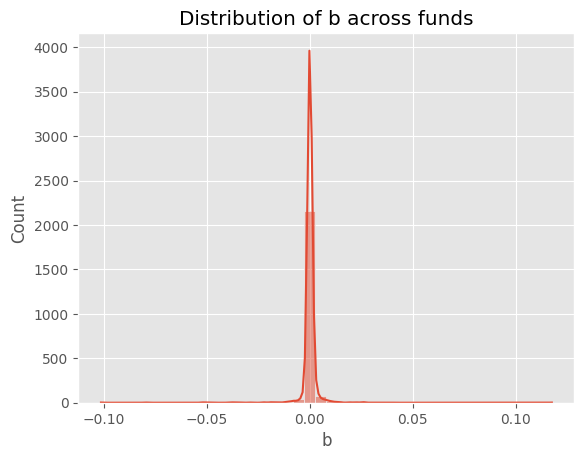

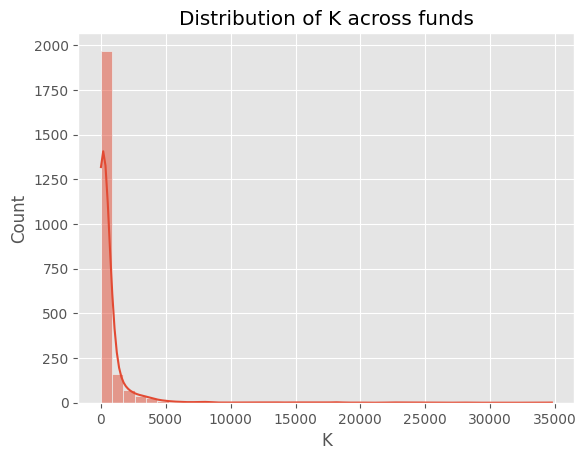

In [14]:
for param in ["a", "b", "K"]:
    sns.histplot(est_df[param], kde=True, bins=40)
    plt.title(f"Distribution of {param} across funds")
    plt.show()



                  K      K_theory        ratio      abs_diff
count   2321.000000  2.321000e+03  2321.000000  2.321000e+03
mean     672.938457 -9.388886e+01     2.803570  7.668273e+02
std     2127.303614  2.774847e+04    84.062794  2.765587e+04
min        0.870801 -1.136250e+06 -1552.751294 -3.383903e+05
25%       56.973520 -2.764388e+01    -0.570822  1.067199e+01
50%      155.355936  2.011534e+01     0.873195  6.078028e+01
75%      469.692781  1.685913e+02     2.017536  2.835161e+02
max    34761.374641  3.391849e+05  3142.043589  1.140950e+06


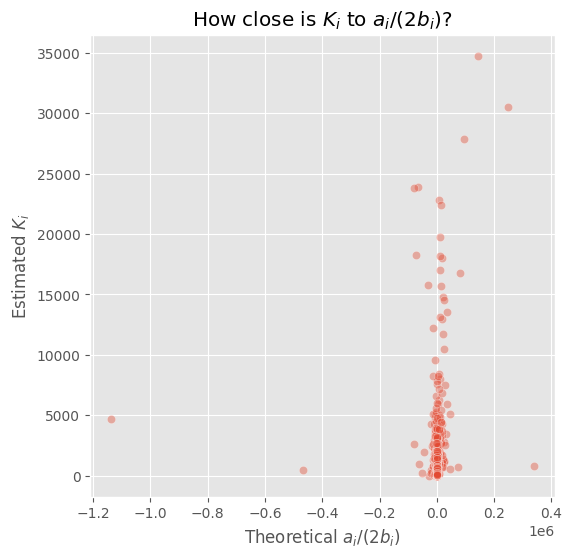

c:\Users\PORTATIL\OneDrive\Documentos\Projects\TFM\TFMvenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


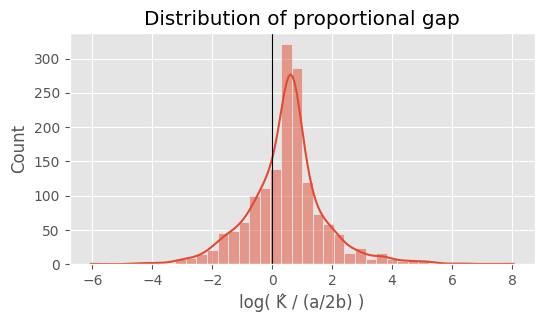

In [15]:
# est_df already has columns 'a', 'b', 'K' (one row per fund)

# 1. Compute the theoretical nonlinearity size
est_df["K_theory"] = est_df["a"] / (2 * est_df["b"])

# 2. Ratio and absolute difference (handle sign issues)
est_df["ratio"] = est_df["K"] / est_df["K_theory"]
est_df["abs_diff"] = est_df["K"] - est_df["K_theory"]

# 3. Quick descriptive stats
summary = est_df[["K", "K_theory", "ratio", "abs_diff"]].describe()
print(summary)

# 4. Scatter-plot with 45° reference
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
sns.scatterplot(data=est_df, x="K_theory", y="K", alpha=.4)
#plt.plot([est_df["K_theory"].min(), est_df["K_theory"].max()],
#         [est_df["K_theory"].min(), est_df["K_theory"].max()],
#         'k--', lw=1)
plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title("How close is $K_i$ to $a_i/(2b_i)$?")
plt.show()

# 5. Histogram of log-ratio (centered at 0 if equal)
plt.figure(figsize=(6,3))
sns.histplot(np.log(est_df["ratio"]), bins=40, kde=True)
plt.axvline(0, color="k", lw=.8)
plt.xlabel(r"log( K̂ / (a/2b) )")
plt.title("Distribution of proportional gap")
plt.show()


In [16]:
def S_h_gauss(q, K, h):
    """
    Gaussian CDF smooth step  ≈ 1{q <= K}.
    Vectorised for NumPy arrays.
    """
    z = (K - q) / (np.sqrt(2.0) * h)
    return 0.5 * (1.0 + erf(z))

In [17]:
def alpha_smooth_gauss(a, b, K, q, h):
    S  = S_h_gauss(q, K, h)
    return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)


In [18]:
def residuals(theta, q, y, F, h):
    a, b, K   = theta[:3]
    betas     = theta[3:]
    alpha_hat = alpha_smooth_gauss(a, b, K, q, h)    # <- swapped
    y_hat     = alpha_hat + F.dot(betas)
    return y_hat - y


In [19]:
TARGET_FUND_ID = 100009           # <-- change this
fund_df = df[df["fund_id"] == TARGET_FUND_ID].copy()

# ------------------------------------------------------------
# 2.  Clean & prepare the vectors
fund_df = fund_df.sort_values("time")
q = fund_df["TNA"].values.astype(float)          # already lagged size
y = fund_df["Y"].values.astype(float)            # excess return
F = fund_df[["F2","F3","F4","F5"]].values.astype(float)

mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
q, y, F = q[mask], y[mask], F[mask]



In [21]:

h = 1  # smoothing bandwidth

In [22]:
a0    = np.mean(y)
b0    = 0.0
K0    = np.median(q)
#K0 = 2000
beta0 = np.linalg.lstsq(F, y, rcond=None)[0]

x0 = np.concatenate(([a0, b0, K0], beta0))
lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

# ------------------------------------------------------------
# 5.  Non-linear least squares (box-constrained)
res = least_squares(residuals, x0, bounds=(lb, ub),
                    args=(q, y, F, h), method="trf", max_nfev=4000)

# ------------------------------------------------------------
# 6.  Results
a_hat, b_hat, K_hat = res.x[:3]
betas_hat = res.x[3:]

print(f"Fund {TARGET_FUND_ID}")
print(f"  â  = {a_hat: .6f}")
print(f"  b̂  = {b_hat: .6f}")
print(f"  K̂  = {K_hat: .6f}")
for j, b_j in enumerate(betas_hat, 1):
    print(f"  β̂{j} = {b_j: .6f}")
print(f"  Converged: {res.success}   |   SSE = {res.cost: .4f}   |   n = {len(q)}")

Fund 100009
  â  =  0.018995
  b̂  =  0.000311
  K̂  =  46.097650
  β̂1 =  1.090132
  β̂2 =  0.738507
  β̂3 = -0.504270
  β̂4 =  0.148673
  Converged: True   |   SSE =  0.1103   |   n = 277


In [23]:
a_hat/(2*b_hat)

np.float64(30.558004510263952)

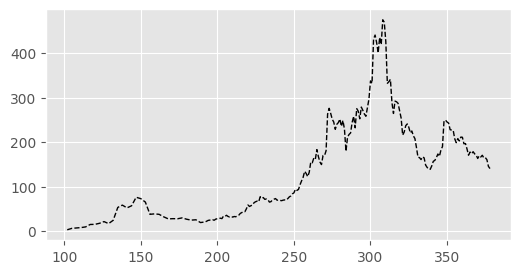

In [24]:
plt.figure(figsize=(6,3))
plt.plot(fund_df["time"], fund_df["TNA"], 'k--', lw=1)

In [25]:
from tqdm import tqdm 

In [26]:
def estimate_one_fund(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # already lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:               # skip tiny time-series
        return None

    # ----- initial guesses -----
    a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

# =============================================================
# 3.  Dataset-wide wrapper
# =============================================================
def estimate_all_funds(df, h=0.01, parallel=False, n_jobs=4):
    """
    Run Gaussian-smooth BG NLLS for every fund in df.
    Returns a DataFrame of estimates.
    Set parallel=True to use ProcessPoolExecutor with n_jobs workers.
    """
    results = []

    if parallel:
        # -------- parallel version --------
        def _worker(item):
            fid, g = item
            est = estimate_one_fund(g, h)
            if est is None: return None
            est["fund_id"] = fid
            return est

        with ProcessPoolExecutor(max_workers=n_jobs) as pool:
            for est in tqdm(pool.map(_worker, df.groupby("fund_id")), total=df["fund_id"].nunique()):
                if est is not None:
                    results.append(est)
    else:
        # -------- serial with progress bar --------
        for fid, g in tqdm(df.groupby("fund_id")):
            est = estimate_one_fund(g, h)
            if est is not None:
                est["fund_id"] = fid
                results.append(est)

    return pd.DataFrame(results)

In [43]:
#similar but using guesses from the linear estimates
def estimate_one_fund_guess(fund_df, h=0.01, lin_map=None):
    """
    Non-linear BG estimator seeded with (a,b) from prior linear fit.
    """
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # already lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    msk = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[msk], y[msk], F[msk]
    if len(q) < 24:
        return None                                # too few observations

    # ---------- initial guesses ---------------------------------------
    fid = fund_df["fund_id"].iloc[0]
    if lin_map is not None and fid in lin_map:
        a0 = lin_map[fid]["a"]
        b0 = lin_map[fid]["b"]
    else:                                          # fallback
        a0 = np.mean(y)
        b0 = 0.0

    K0    = np.median(q)                           # still data-driven
    beta0 = np.linalg.lstsq(F, y, rcond=None)[0]

    x0 = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "fund_id": fid,
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

def estimate_all_funds_guess(df, h=0.01, parallel=False, n_jobs=4, lin_map=None):
    results = []

    if parallel:
        from concurrent.futures import ProcessPoolExecutor

        def _worker(item):
            fid, g = item
            return estimate_one_fund_guess(g, h=h, lin_map=lin_map)

        with ProcessPoolExecutor(max_workers=n_jobs) as pool:
            for out in tqdm(pool.map(_worker, df.groupby("fund_id")),
                            total=df["fund_id"].nunique()):
                if out is not None:
                    results.append(out)
    else:
        for fid, g in tqdm(df.groupby("fund_id")):
            out = estimate_one_fund_guess(g, h=h, lin_map=lin_map)
            if out is not None:
                results.append(out)

    return pd.DataFrame(results)



In [28]:
df = df.sort_values(["fund_id","time"])  
estimates = estimate_all_funds(df, h=0.01, parallel=False) 

100%|██████████| 2321/2321 [00:38<00:00, 60.14it/s]


In [29]:
estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])


In [30]:
# Optional: drop weird cases (b <= 0 or K_theory NaN/inf)
clean = estimates.replace([np.inf, -np.inf], np.nan).dropna(subset=["K","K_theory"])
#clean = clean[clean["b"] > 0]          # keeps only economically sensible slope

# -------------------------------------------------------------
# 4.  Summary stats
print(clean[["K", "K_theory"]]
      .assign(ratio=clean["K"]/clean["K_theory"])
      .describe(percentiles=[.1,.25,.5,.75,.9]))


                  K      K_theory        ratio
count   2321.000000  2.321000e+03  2321.000000
mean     628.045070  2.127978e+03     2.277931
std     2149.562528  7.502200e+04    47.688285
min        0.045150 -1.244651e+05  -967.616309
10%       28.310775 -5.645690e+01    -1.997546
25%       56.932674  6.899152e+00     0.637198
50%      151.572386  3.761654e+01     1.784961
75%      457.174449  1.873534e+02     2.521888
90%     1141.245195  8.098825e+02     5.180036
max    40761.866136  3.596033e+06  1470.642367


In [31]:
def alpha_linear(a, b, q):
    """Restricted single-regime α(q) = a – b q."""
    return a - b*q

def residuals_linear(theta, q, y, F, h):
    a, b, K   = theta[:3]
    betas     = theta[3:]
    alpha_hat = alpha_linear(a, b, q)  
    y_hat     = alpha_hat + F.dot(betas)
    return y_hat - y

def estimate_one_fund_lin(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # already lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:               # skip tiny time-series
        return None

    # ----- initial guesses -----
    a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals_linear, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

# =============================================================
# 3.  Dataset-wide wrapper
# =============================================================
def estimate_all_funds_linear(df, h=0.01, parallel=False, n_jobs=4):
    """
    Run Gaussian-smooth OLS for every fund in df.
    Returns a DataFrame of estimates.
    Set parallel=True to use ProcessPoolExecutor with n_jobs workers.
    """
    results = []

    if parallel:
        # -------- parallel version --------
        def _worker(item):
            fid, g = item
            est = estimate_one_fund_lin(g, h)
            if est is None: return None
            est["fund_id"] = fid
            return est

        with ProcessPoolExecutor(max_workers=n_jobs) as pool:
            for est in tqdm(pool.map(_worker, df.groupby("fund_id")), total=df["fund_id"].nunique()):
                if est is not None:
                    results.append(est)
    else:
        # -------- serial with progress bar --------
        for fid, g in tqdm(df.groupby("fund_id")):
            est = estimate_one_fund_lin(g, h)
            if est is not None:
                est["fund_id"] = fid
                results.append(est)

    return pd.DataFrame(results)


In [32]:
df = df.sort_values(["fund_id","time"])  
estimates_lin = estimate_all_funds_linear(df, h=0.01, parallel=False) 

100%|██████████| 2321/2321 [00:12<00:00, 180.07it/s]


In [33]:
# Optional: drop weird cases (b <= 0 or K_theory NaN/inf)
clean_lin = estimates_lin.replace([np.inf, -np.inf], np.nan).dropna(subset=["K"])
#clean = clean[clean["b"] > 0]          # keeps only economically sensible slope

# -------------------------------------------------------------
# 4.  Summary stats
print(clean_lin[["K"]].describe(percentiles=[.1,.25,.5,.75,.9]))

                  K
count   2321.000000
mean    1213.748990
std     3724.437907
min        0.000003
10%       57.963559
25%      118.866102
50%      312.939359
75%      960.415215
90%     2452.725305
max    69694.657794


In [34]:
estimates_lin["K_theory"] = estimates_lin["a"] / (2 * estimates_lin["b"])

print(estimates_lin[["K", "K_theory"]]
      .assign(ratio=estimates_lin["K"]/estimates_lin["K_theory"])
      .describe(percentiles=[.1,.25,.5,.75,.9]))

                  K      K_theory        ratio
count   2321.000000  2.321000e+03  2321.000000
mean    1213.748990  2.759483e+03     1.559394
std     3724.437907  7.438083e+04    28.910692
min        0.000003 -6.925237e+04  -418.327585
10%       57.963559 -3.911556e+01    -0.439401
25%      118.866102  3.349467e+01     0.339643
50%      312.939359  1.825065e+02     1.384148
75%      960.415215  7.908849e+02     2.555152
90%     2452.725305  2.922941e+03     4.456378
max    69694.657794  3.574184e+06  1003.157950


In [35]:
estimates_lin.head()

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,fund_id,K_theory
0,0.001492,-2.660309e-07,5180.947803,0.962015,-0.018759,0.051107,0.028328,0.018089,True,386,100001,-2804.264630
1,0.004300,1.583310e-06,1377.344778,1.009327,0.619777,-0.017121,0.039970,0.054565,True,316,100003,1357.875382
2,0.004346,1.460467e-06,2127.060611,1.009456,0.147759,-0.277096,0.028058,0.037292,True,419,100004,1487.950851
3,0.006741,5.913177e-07,1815.040098,0.843809,0.142745,0.331572,0.036263,0.011378,True,184,100006,5700.289753
4,0.007891,1.787235e-05,145.937412,1.085414,0.732124,-0.504707,0.145129,0.112468,True,277,100009,220.759662


In [39]:
lin_lookup = (estimates_lin
              .set_index("fund_id")[["a","b"]]
              .to_dict("index"))    

In [44]:
df = df.sort_values(["fund_id", "time"])
estimates = estimate_all_funds_guess(df, h=0.01, parallel=False, lin_map=lin_lookup)

100%|██████████| 2321/2321 [00:44<00:00, 52.27it/s]


In [46]:

estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])

clean = estimates.replace([np.inf, -np.inf], np.nan).dropna(subset=["K","K_theory"])
#clean = clean[clean["b"] > 0]         

# -------------------------------------------------------------
# 4.  Summary stats
print(clean[["K", "K_theory"]]
      .assign(ratio=clean["K"]/clean["K_theory"])
      .describe(percentiles=[.1,.25,.5,.75,.9]))

                  K      K_theory        ratio
count   2321.000000  2.321000e+03  2321.000000
mean     709.610461  2.372058e+03     2.385259
std     2828.909205  7.900588e+04    48.944086
min        0.253188 -2.995831e+04  -967.687571
10%       28.406062 -4.984589e+01    -2.119659
25%       57.797759  7.501773e+00     0.693210
50%      160.827941  3.809279e+01     1.851339
75%      477.034920  1.876267e+02     2.705415
90%     1258.530116  7.911041e+02     5.413538
max    74083.475090  3.767712e+06  1471.642760


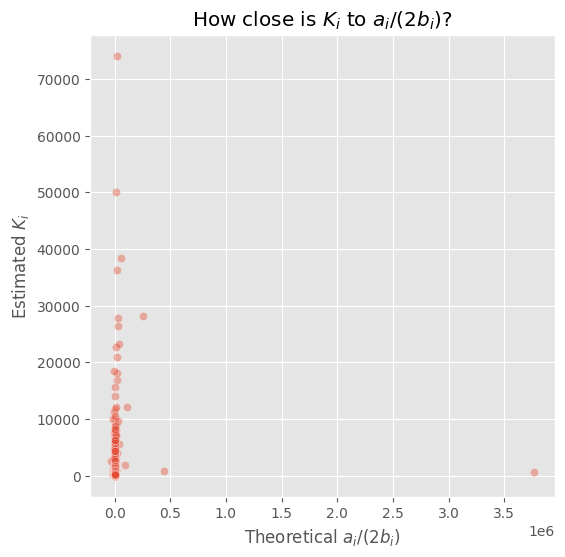

In [47]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=clean, x="K_theory", y="K", alpha=.4)
#plt.plot([est_df["K_theory"].min(), est_df["K_theory"].max()],
#         [est_df["K_theory"].min(), est_df["K_theory"].max()],
#         'k--', lw=1)
plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title("How close is $K_i$ to $a_i/(2b_i)$?")
plt.show()

In [48]:
q10, q90 = clean["K_theory"].quantile([0.10, 0.90])

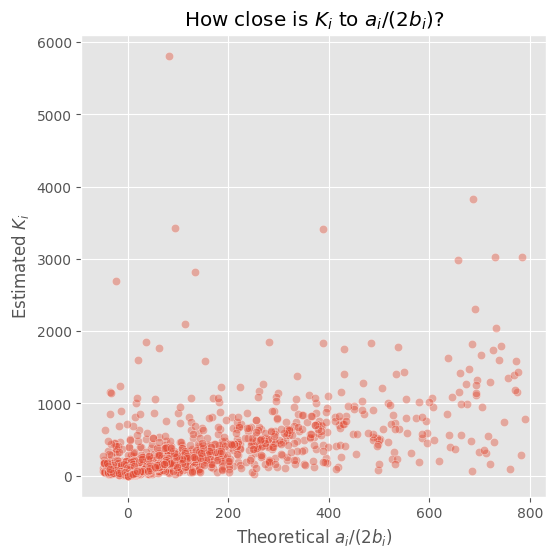

In [49]:

plt.figure(figsize=(6,6))
sns.scatterplot(data=clean[(clean["K_theory"] >= q10) & (clean["K_theory"] <= q90)], x="K_theory", y="K", alpha=.4)
#plt.plot([est_df["K_theory"].min(), est_df["K_theory"].max()],
#         [est_df["K_theory"].min(), est_df["K_theory"].max()],
#         'k--', lw=1)
plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title("How close is $K_i$ to $a_i/(2b_i)$?")
plt.show()

H robustness

Estimating for each h:  17%|█▋        | 1/6 [00:48<04:04, 48.81s/it]

  -> saved estimates_h0.5.csv  (2321 funds)


Estimating for each h:  33%|███▎      | 2/6 [01:35<03:10, 47.54s/it]

  -> saved estimates_h0.1.csv  (2321 funds)


Estimating for each h:  50%|█████     | 3/6 [02:24<02:24, 48.04s/it]

  -> saved estimates_h0.01.csv  (2321 funds)


Estimating for each h:  67%|██████▋   | 4/6 [03:16<01:39, 49.63s/it]

  -> saved estimates_h0.001.csv  (2321 funds)


Estimating for each h:  83%|████████▎ | 5/6 [04:06<00:49, 49.77s/it]

  -> saved estimates_h0.0001.csv  (2321 funds)


Estimating for each h: 100%|██████████| 6/6 [04:54<00:00, 49.02s/it]


  -> saved estimates_h1e-06.csv  (2321 funds)
(1857, 12)
(1857, 12)
(1857, 12)
(1857, 12)
(1857, 12)
(1857, 12)


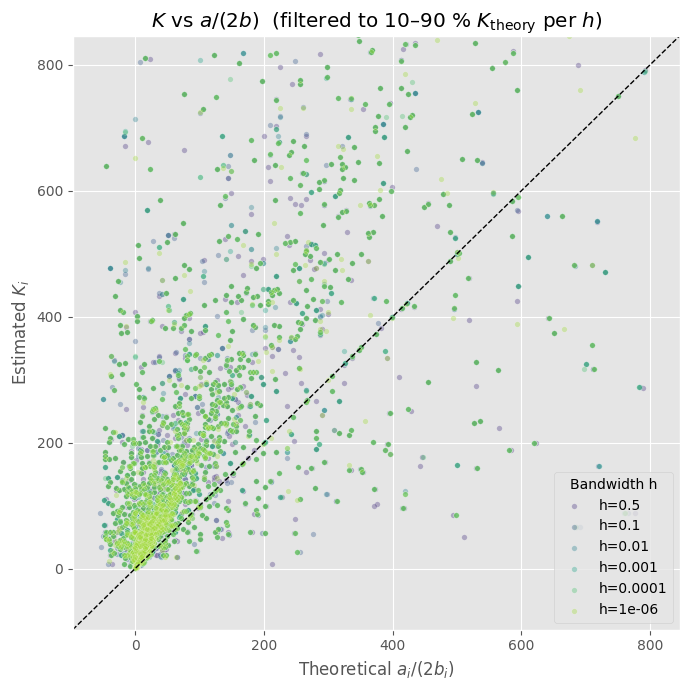

In [52]:
h_list = [0.5, 0.1, 0.01, 0.001, 0.0001, 0.000001]
df     = df.sort_values(["fund_id", "time"])      # make sure sorted

# ------------------------------------------------------------------
# 1.  Run estimation & store results in a dict
# ------------------------------------------------------------------
all_estimates = {}          # {h: DataFrame}

for h in tqdm(h_list, desc="Estimating for each h"):
    est = estimate_all_funds_guess(df, h=h, parallel=False, lin_map=lin_lookup)
    est["K_theory"] = est["a"] / (2 * est["b"])
    fname = f"estimates_h{h}.csv"
    est.to_csv(fname, index=False)
    all_estimates[h] = est
    print(f"  -> saved {fname}  ({len(est)} funds)")

# ------------------------------------------------------------------
# 2.  Plot K vs K_theory for each h (10–90 % range per h)
# ------------------------------------------------------------------
plt.figure(figsize=(7,7))
palette = sns.color_palette("viridis", len(h_list))

for h, color in zip(h_list, palette):
    est = all_estimates[h].replace([np.inf, -np.inf], np.nan) \
                           .dropna(subset=["K", "K_theory"])

    q10, q90 = est["K_theory"].quantile([0.10, 0.90])
    slice_   = est[(est["K_theory"] >= q10) & (est["K_theory"] <= q90)]
    print(slice_.shape)

    sns.scatterplot(data=slice_, x="K_theory", y="K",
                    s=16, alpha=0.35, label=f"h={h}", color=color)

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()
plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title(r"$K$ vs $a/(2b)$  (filtered to 10–90 % $K_{\text{theory}}$ per $h$)")
plt.legend(title="Bandwidth h")
plt.tight_layout()
plt.show()

(2181, 12)
(2181, 12)
(2181, 12)
(2181, 12)
(2181, 12)
(2181, 12)


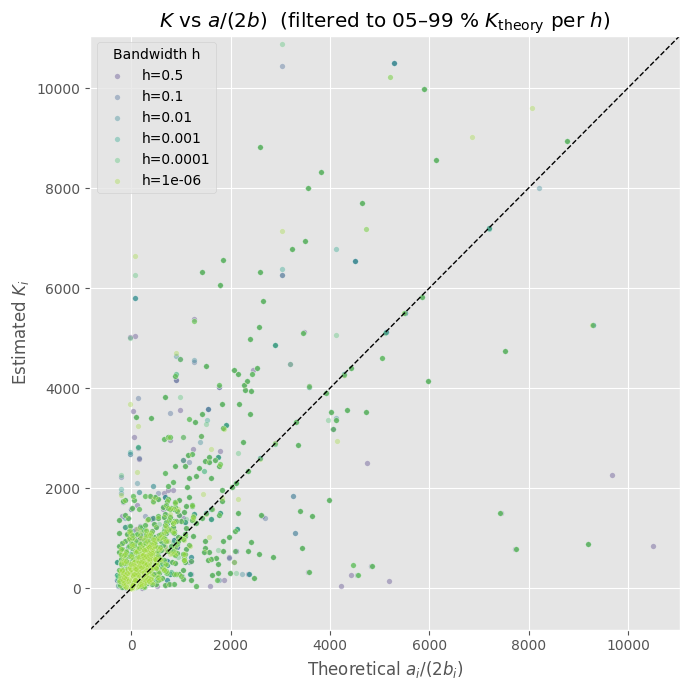

In [57]:
plt.figure(figsize=(7,7))
palette = sns.color_palette("viridis", len(h_list))

for h, color in zip(h_list, palette):
    est = all_estimates[h].replace([np.inf, -np.inf], np.nan) \
                           .dropna(subset=["K", "K_theory"])

    q5, q95 = est["K_theory"].quantile([0.05, 0.99])
    slice_   = est[(est["K_theory"] >= q5) & (est["K_theory"] <= q95)]
    print(slice_.shape)

    sns.scatterplot(data=slice_, x="K_theory", y="K",
                    s=16, alpha=0.35, label=f"h={h}", color=color)

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()
plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title(r"$K$ vs $a/(2b)$  (filtered to 05–99 % $K_{\text{theory}}$ per $h$)")
plt.legend(title="Bandwidth h")
plt.tight_layout()
plt.show()

Estimating for each h:  50%|█████     | 1/2 [00:39<00:39, 39.76s/it]

  -> saved estimates_h1e-10.csv  (2321 funds)


Estimating for each h: 100%|██████████| 2/2 [01:17<00:00, 38.77s/it]


  -> saved estimates_h1e-16.csv  (2321 funds)


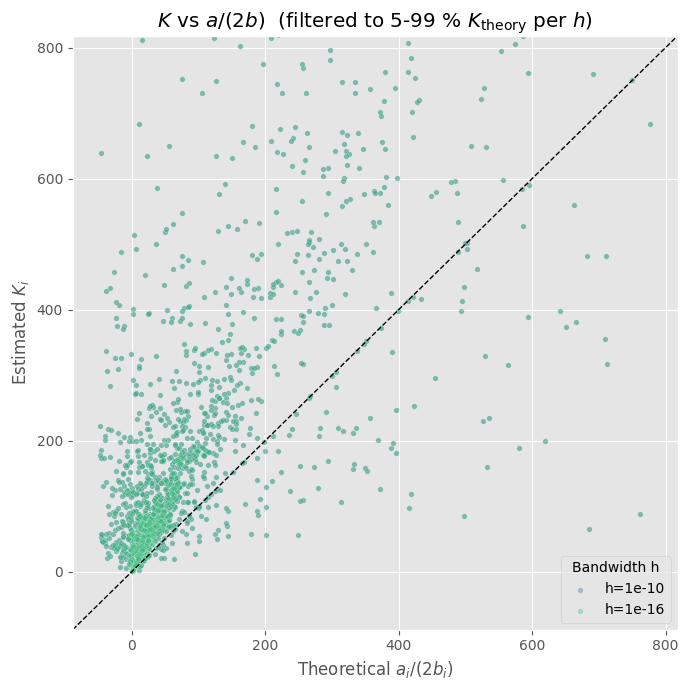

In [73]:
h_list = [0.0000000001, 0.0000000000000001]
df     = df.sort_values(["fund_id", "time"])      # make sure sorted

# ------------------------------------------------------------------
# 1.  Run estimation & store results in a dict
# ------------------------------------------------------------------
all_estimates = {}          # {h: DataFrame}

for h in tqdm(h_list, desc="Estimating for each h"):
    est = estimate_all_funds_guess(df, h=h, parallel=False, lin_map=lin_lookup)
    est["K_theory"] = est["a"] / (2 * est["b"])
    fname = f"estimates_h{h}.csv"
    est.to_csv(fname, index=False)
    all_estimates[h] = est
    print(f"  -> saved {fname}  ({len(est)} funds)")

# ------------------------------------------------------------------
# 2.  Plot K vs K_theory for each h (10–90 % range per h)
# ------------------------------------------------------------------
plt.figure(figsize=(7,7))
palette = sns.color_palette("viridis", len(h_list))

for h, color in zip(h_list, palette):
    est = all_estimates[h].replace([np.inf, -np.inf], np.nan) \
                           .dropna(subset=["K", "K_theory"])

    q5, q99 = est["K_theory"].quantile([0.5, 0.99])
    slice_   = est[(est["K_theory"] >= q10) & (est["K_theory"] <= q90)]

    sns.scatterplot(data=slice_, x="K_theory", y="K",
                    s=16, alpha=0.35, label=f"h={h}", color=color)

# 45° reference line (on union of plotted data)
lims = plt.gca().get_xlim()
plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title(r"$K$ vs $a/(2b)$  (filtered to 5-99 % $K_{\text{theory}}$ per $h$)")
plt.legend(title="Bandwidth h")
plt.tight_layout()
plt.show()

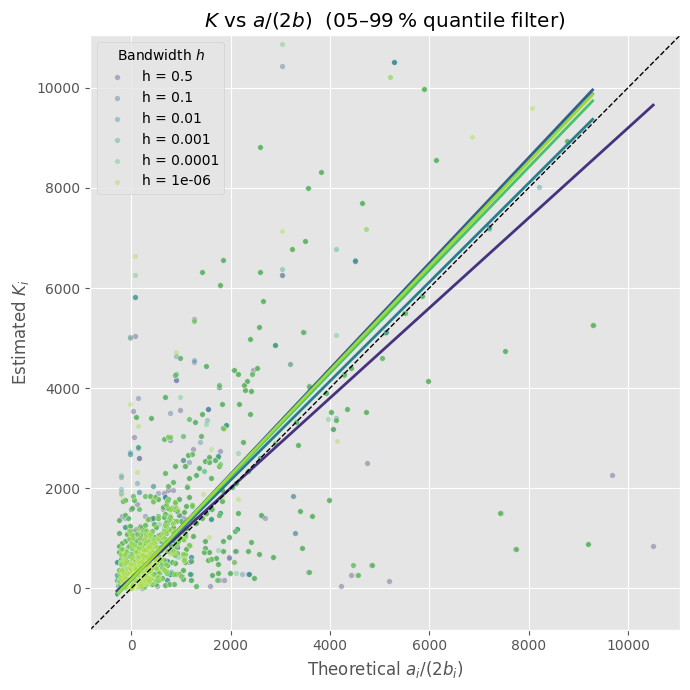

           h         beta      se_beta           R2
0.5000000000 0.8993513990 0.0179837033 0.5343941916
0.1000000000 1.0536696561 0.0186757511 0.5936307564
0.0100000000 0.9889060640 0.0177982033 0.5862252427
0.0010000000 1.0444805375 0.0181976334 0.6018897839
0.0001000000 1.0289815682 0.0182190818 0.5941358081
0.0000010000 1.0427792272 0.0180061354 0.6061704644


In [72]:
stats = []

plt.figure(figsize=(7,7))
palette = sns.color_palette("viridis", len(h_list))

for h, color in zip(h_list, palette):
    # ---------- 1. prep the slice exactly as you had ----------
    est  = (all_estimates[h]
               .replace([np.inf, -np.inf], np.nan)
               .dropna(subset=["K", "K_theory"]))
    q5, q95 = est["K_theory"].quantile([0.05, 0.99])
    slice_  = est[(est["K_theory"] >= q5) & (est["K_theory"] <= q95)]

    # ---------- 2. scatter points ----------
    sns.scatterplot(data=slice_, x="K_theory", y="K",
                    s=16, alpha=0.35, label=f"h = {h}", color=color)

    # ---------- 3. fitted line K = α + β·K_theory ----------
    slope, intercept, r, p, se = linregress(slice_["K_theory"], slice_["K"])
    x_line = np.array([slice_["K_theory"].min(), slice_["K_theory"].max()])
    y_line = intercept + slope * x_line
    plt.plot(x_line, y_line, color=color, lw=2)

    # (optional) annotate R² next to the line:
    #plt.text(x_line.mean(), y_line.mean(),
    #         f"$\\hat{{\\beta}}={slope:.2f}$\n$R^2={r**2:.2f}$",
    #         color=color, fontsize=20, ha="left", va="bottom")

# ---------- 4. store stats ----------
    stats.append({"h": h, "beta": slope, "se_beta": se, "R2": r**2})
# ---------- 45° reference ----------
lims = plt.gca().get_xlim()
plt.plot(lims, lims, 'k--', lw=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel(r"Theoretical $a_i/(2b_i)$")
plt.ylabel(r"Estimated $K_i$")
plt.title(r"$K$ vs $a/(2b)$  (05–99 % quantile filter)")
plt.legend(title="Bandwidth $h$")
plt.tight_layout()
plt.show()

summary = pd.DataFrame(stats)
print(summary.to_string(index=False, float_format="%.10f"))